In [1]:
import os
import glob
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Plotting style
sns.set_theme(style='whitegrid')

# ===========================
# Load and clean the data
# ===========================
base_dir = "analysis/abide"
selected_rois = ['Temporal Region',
                 'Prefrontal Cortex',
                 'Cingulate Cortex',
                 'Amygdala',
                 'Hippocampus',
                 'Insula',
                 'Cerebellum'
]


def load_and_filter_data(files, group_name, selected_rois=None):
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        df['source_file'] = file
        df['group'] = group_name
        if selected_rois is not None:
            df = df[df['Region'].isin(selected_rois)]
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)


asd_files = glob.glob(os.path.join(base_dir, "*", "patient", "metrics", "abide_roi_metrics.csv"))
asd_data = load_and_filter_data(asd_files, 'ASD', selected_rois)

control_files = glob.glob(os.path.join(base_dir, "*", "control", "metrics", "abide_roi_metrics.csv"))
control_data = load_and_filter_data(control_files, 'Control', selected_rois)

all_data = pd.concat([asd_data, control_data], ignore_index=True)
all_data.dropna(inplace=True)


# Extract age bin from file path
def extract_age_bin(path):
    match = re.search(r"abide[\\/](.*?)[\\/]", path)
    return match.group(1) if match else "unknown"


all_data['age_bin'] = all_data['source_file'].apply(extract_age_bin)
age_bin_order = ["11-", "12_17", "18_25", "25+"]
all_data['age_bin'] = pd.Categorical(all_data['age_bin'], categories=age_bin_order, ordered=True)


# Pivot data by subject
def create_pivot(df):
    subject_ages = df.groupby('SubjectID')['Age'].first()
    subject_bins = df.groupby('SubjectID')['age_bin'].first()
    pivot_df = df.pivot_table(index='SubjectID', columns='Region', values=['Closeness', 'Clustering', 'Degree'])
    pivot_df.columns = [f'{metric}_{roi}' for metric, roi in pivot_df.columns]
    pivot_df.reset_index(inplace=True)
    pivot_df['Age'] = pivot_df['SubjectID'].map(subject_ages)
    pivot_df['age_bin'] = pivot_df['SubjectID'].map(subject_bins)
    return pivot_df


asd_pivot_df = create_pivot(all_data[all_data['group'] == 'ASD']).dropna()
asd_pivot_df['group'] = 'ASD'

control_pivot_df = create_pivot(all_data[all_data['group'] == 'Control']).dropna()
control_pivot_df['group'] = 'Control'

In [2]:
# ===========================
# HMM per ogni metrica (ASD)
# ===========================

from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm

def train_hmm_by_metric(df, metrics, n_states=2, n_seeds=10, prefix='ASD'):
    for metric in metrics:
        print(f"\n🔍 Addestramento HMM su metrica: {metric}")

        metric_cols = [col for col in df.columns if col.startswith(metric)]
        X = df[metric_cols].values

        # Rimuove feature con varianza nulla
        variances = X.var(axis=0)
        X = X[:, variances > 0]
        valid_cols = [col for i, col in enumerate(metric_cols) if variances[i] > 0]

        if X.shape[1] == 0:
            print(f"⚠️ Nessuna feature valida per {metric}")
            continue

        # Standardizzazione
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # HMM multiseed
        best_model = None
        best_score = -np.inf

        for seed in range(n_seeds):
            try:
                model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=400, random_state=seed)
                model.fit(X_scaled)
                score = model.score(X_scaled)
                if not np.isnan(score) and score > best_score:
                    best_model = model
                    best_score = score
            except Exception as e:
                print(f"  ⚠️ Errore HMM (seed {seed}): {e}")

        if best_model is not None:
            hidden_states = best_model.predict(X_scaled)
            state_col = f"{prefix}_{metric}_state"
            df[state_col] = hidden_states
            print(f"✅ Colonna '{state_col}' aggiunta.")
        else:
            print(f"❌ Nessun modello HMM valido per {metric}")

# Applica su ASD
metrics = ['Closeness', 'Clustering', 'Degree']
train_hmm_by_metric(asd_pivot_df, metrics, n_states=3, n_seeds=10, prefix='ASD')



🔍 Addestramento HMM su metrica: Closeness
✅ Colonna 'ASD_Closeness_state' aggiunta.

🔍 Addestramento HMM su metrica: Clustering
✅ Colonna 'ASD_Clustering_state' aggiunta.

🔍 Addestramento HMM su metrica: Degree
✅ Colonna 'ASD_Degree_state' aggiunta.


In [3]:
from collections import Counter

def simulate_trajectories(df, state_column, age_bins, n_bootstraps=1000):
    state_trajectories = []

    for b in range(n_bootstraps):
        trajectory = []
        valid = True
        for bin_label in age_bins:
            candidates = df[df['age_bin'] == bin_label]
            if candidates.empty or state_column not in candidates.columns:
                valid = False
                break
            chosen = candidates.sample(n=1, random_state=b)
            state = chosen[state_column].values[0]
            trajectory.append(state)
        if valid:
            state_trajectories.append(tuple(trajectory))

    return state_trajectories


In [4]:
age_bins = age_bin_order  # ["11-", "12_17", "18_25", "25+"]
n_bootstraps = 1000

trajectory_dict = {}

for metric in metrics:
    state_col = f"ASD_{metric}_state"
    if state_col in asd_pivot_df.columns:
        print(f"\n📈 Simulazione traiettorie per metrica: {metric}")
        trajectories = simulate_trajectories(asd_pivot_df, state_col, age_bins, n_bootstraps=n_bootstraps)
        counts = Counter(trajectories)
        most_common = counts.most_common(5)
        print("Traiettorie più frequenti:")
        for i, (traj, count) in enumerate(most_common):
            print(f"  {i+1}. {traj} (frequenza: {count})")
        trajectory_dict[metric] = trajectories



📈 Simulazione traiettorie per metrica: Closeness
Traiettorie più frequenti:
  1. (2, 2, 2, 2) (frequenza: 210)
  2. (0, 2, 2, 2) (frequenza: 163)
  3. (2, 2, 0, 2) (frequenza: 92)
  4. (0, 2, 0, 2) (frequenza: 78)
  5. (2, 2, 2, 0) (frequenza: 76)

📈 Simulazione traiettorie per metrica: Clustering
Traiettorie più frequenti:
  1. (0, 1, 1, 1) (frequenza: 126)
  2. (0, 0, 1, 1) (frequenza: 85)
  3. (0, 1, 0, 1) (frequenza: 79)
  4. (1, 1, 1, 1) (frequenza: 70)
  5. (0, 0, 0, 1) (frequenza: 58)

📈 Simulazione traiettorie per metrica: Degree
Traiettorie più frequenti:
  1. (0, 2, 2, 2) (frequenza: 116)
  2. (0, 0, 2, 2) (frequenza: 90)
  3. (0, 2, 0, 2) (frequenza: 60)
  4. (0, 0, 0, 2) (frequenza: 56)
  5. (2, 2, 2, 2) (frequenza: 43)



🔄 Transizioni HMM - metrica: Closeness


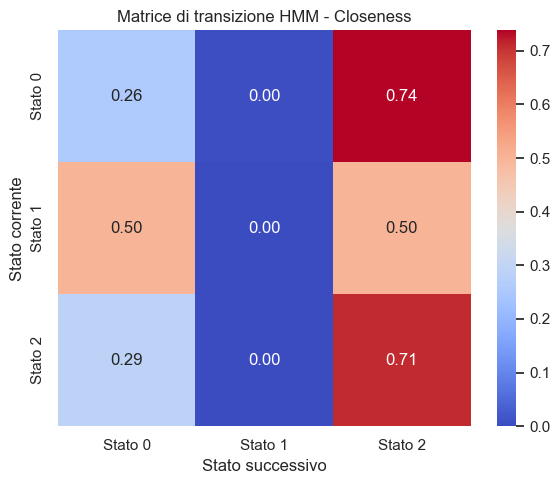


🔄 Transizioni HMM - metrica: Clustering


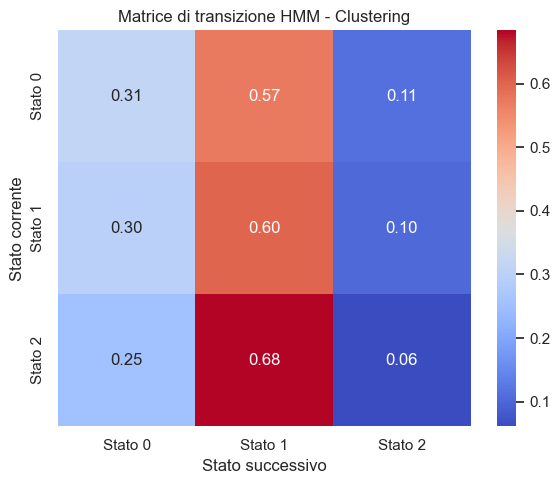


🔄 Transizioni HMM - metrica: Degree


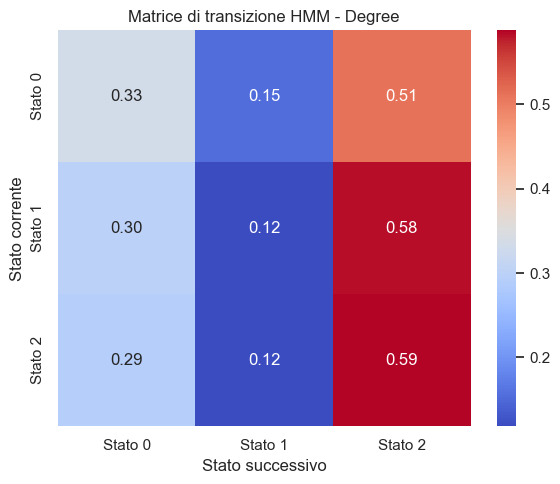

In [5]:
for metric, trajectories in trajectory_dict.items():
    print(f"\n🔄 Transizioni HMM - metrica: {metric}")
    n_states = 3
    transition_counts = np.zeros((n_states, n_states), dtype=int)

    for traj in trajectories:
        for (s1, s2) in zip(traj[:-1], traj[1:]):
            transition_counts[s1, s2] += 1

    transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(transition_probs, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=[f'Stato {i}' for i in range(n_states)],
                yticklabels=[f'Stato {i}' for i in range(n_states)])
    plt.title(f"Matrice di transizione HMM - {metric}")
    plt.xlabel("Stato successivo")
    plt.ylabel("Stato corrente")
    plt.tight_layout()
    plt.show()
